# Project 1 - Revisited

- Robert Yonce
- 5/24/23

# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np

# Modeling & Preprocessing import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer,make_column_transformer,make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
# Load in the data

df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTOdd9ucw6tCewOdXmi_zGCnXLdAtUKs1-k5KgSD6TDSkPx6z4ptifobdRcUE-JYhX6IIBziuMvQoVZ/pub?output=csv')

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Cleaning Data

## Duplicate Check

In [3]:
# Checking for Duplicates

df.duplicated().sum()

0

In [4]:
# Checking Dtype and missing counts

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Value Check for Item Fat Content

In [5]:
# Checking value of Item Fat Content

df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [6]:
# Replacing value and making two total values

df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Create Target

In [7]:
# Identify the features (X) and target (y): 
# Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.

X = df.drop(columns = ['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Establishment_Year', 'Outlet_Identifier'])

y = df['Item_Outlet_Sales']

# Create Split and Preprocessor

In [8]:
# Perform a train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [9]:
## Create a preprocessing object to prepare the dataset for Machine Learning

# SimpleImputers with most_frequent and median strategies plus scaler and OHE

freq_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)

# Prepare separate processing pipelines for numeric and categorical data

num_pipe = make_pipeline(median_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

# Selectors to for numeric and categorical data types

num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

# Create tuples of (imputer, selector) for each datatype

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

# Create the preprocessing ColumnTransformer

preprocessor = make_column_transformer(cat_tuple, num_tuple, verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15bacc580>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15bacc490>)],
                  verbose_feature_names_out=False)

# Create DF with X

In [10]:
# Fit column transformer and run get_feature_names_out

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Item_Weight', 'Item_Visibility',
       'Item_MRP'], dtype=object)

In [11]:
# DF with X train

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)


,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP
4776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.827485,-0.712775,1.828109
7510,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.566644,-1.291052,0.603369
5828,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.121028,1.813319,0.244541


In [12]:
# DF with X test

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP
7503,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.341372,-0.776646,-0.998816
2957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.169135,0.100317,-1.585194
7031,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.388798,-0.482994,-1.595784


In [13]:
# Confirm the first 3 rows index in y_test matches X_test_df

y_test.head(3)

7503    1743.0644
2957     356.8688
7031     377.5086
Name: Item_Outlet_Sales, dtype: float64

# Create Linear Regression Model 

In [14]:
# Function for Model

def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [15]:
# Linear regression model

linreg = LinearRegression()
linreg.fit(X_train_df,y_train)
evaluate_regression(linreg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1141.39
Test Data:	R^2= 0.57	RMSE= 1095.35


## Pull Coefficients and Show Importance

In [16]:
# Pull Coeffs

coeffs = pd.Series(linreg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = linreg.intercept_
coeffs.head()

Item_Fat_Content_Low Fat   -2.869290e+16
Item_Fat_Content_Regular   -2.869290e+16
Item_Type_Baking Goods      6.475001e+15
Item_Type_Breads            6.475001e+15
Item_Type_Breakfast         6.475001e+15
Name: Coefficients, dtype: float64

In [17]:
# Pulled Function from Class

def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

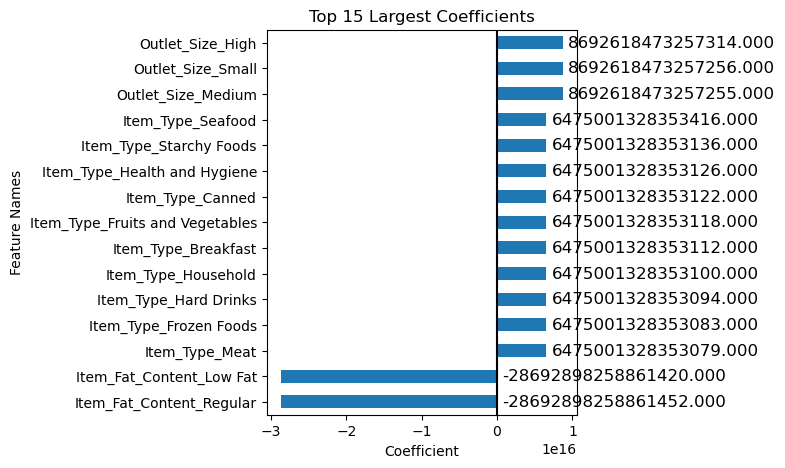

In [18]:
# Plot on graph

plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);

## Top 3 Coefficients

Top 3 Coefficients:

    - Outlet_Size_High: That for every time the product is in High Outlet Size, the value shown will increase the Item Outlet Sale.
    
    - Outlet_Size_Small: That for every time the product is in Small Outlet Size, the value shown will increase the Item Outlet Sale.
    
    
    - Outlet_Size_Med: That for every time the product is in Med Outlet Size, the value shown will increase the Item Outlet Sale.
    

# Create Decision Tree Model

In [19]:
# Create an instance of the model

dec_tree = DecisionTreeRegressor()
dec_tree.fit(X_train_df,y_train)
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.11	RMSE= 1570.34


## Features for Model

In [20]:
# Pull the Features

feature_importance = pd.Series(dec_tree.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()

Item_Fat_Content_Low Fat    0.005186
Item_Fat_Content_Regular    0.003378
Item_Type_Baking Goods      0.003074
Item_Type_Breads            0.003544
Item_Type_Breakfast         0.002988
Name: Feature Importances, dtype: float64

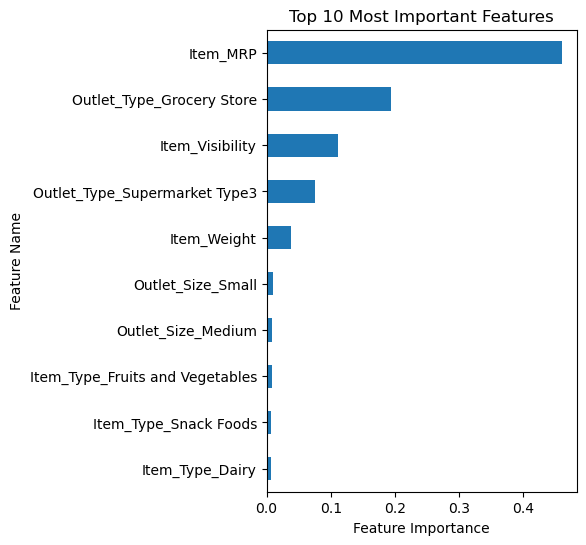

In [21]:
# Map the Model Features

ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

## Top 5 Features

Top 5 Features:

    - Item MRP
    - Outlet Type Grocery Store
    - Item Visibility
    - Outlet Type Supermarket Type3
    - Item Weight

# Saving Models

In [22]:
# Saving Variables

import joblib

# Creating a dictionary of all of the variables to save for later
export = {'preprocessor':preprocessor,
          'X_train':X_train_df,
          'X_test':X_test_df,
          'y_train': y_train,
          'y_test': y_test,
          'LinearRegression': linreg,
          'DecisionTree':dec_tree}
joblib.dump(export, 'salesmodel_l01.joblib')

['salesmodel_l01.joblib']